In [8]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.backend_bases
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 
from sklearn.compose import make_column_selector

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag # for bagging
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance

#eda
import pandas_profiling

# Misc
import warnings
warnings.filterwarnings("ignore")

## Explore data

In [48]:
df = pd.read_csv("df.csv")

In [49]:
df.describe()

,year,total_mwh,total_cust,no,saidi_nomed,circuits,voltage,gen_mwh,purchase_mwh,pv_mwh,...,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,pv_pct,wind_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
count,2699.000000,2.699000e+03,2.699000e+03,2699.000000,2699.000000,2699.000000,2699.000000,1.534000e+03,2.699000e+03,2699.000000,...,2699.000000,2.699000e+03,2.699000e+03,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000
mean,2017.140422,3.149517e+06,1.482996e+05,11953.952205,132.107830,202.028159,51.051501,3.817798e+06,1.930104e+06,872.834801,...,904.241550,2.986024e+04,1.192375e+04,1129.133774,0.033374,0.002732,0.037360,0.353077,0.020304,4.378855
std,1.462375,9.435886e+06,4.606789e+05,7908.112320,185.674422,510.849556,224.569432,1.218682e+07,4.816731e+06,7740.335961,...,7786.815114,1.406401e+05,7.649018e+04,24925.414395,0.169005,0.017980,0.174422,1.039859,0.190279,13.255037
min,2015.000000,3.294000e+03,3.420000e+02,97.000000,0.000000,1.000000,0.000000,-2.670000e+03,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,2.856545e+05,1.155600e+04,5585.000000,50.851500,33.000000,0.000000,0.000000e+00,2.736575e+05,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,5.650260e+05,2.608500e+04,11740.000000,96.000000,60.000000,0.000000,4.850000e+01,5.706570e+05,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,1.341410e+06,6.374250e+04,16679.000000,162.784500,122.000000,22.000000,3.130125e+05,1.342214e+06,50.910500,...,58.038000,1.299500e+03,4.000000e+01,0.000000,0.007315,0.000000,0.008188,0.237519,0.000000,0.050169
max,2019.000000,1.119557e+08,5.069189e+06,57483.000000,6356.070000,5619.000000,2787.000000,1.265085e+08,7.229354e+07,174137.899000,...,174137.899000,2.865573e+06,1.323922e+06,977215.000000,2.737364,0.334026,2.737446,13.437062,3.509534,100.000000


In [50]:
df.sort_values(['gen_mwh']).filter(['name','gen_mwh']).head(2)

,name,gen_mwh
1913,City of Key West - (FL),-2670.0
2372,Indianola Municipal Utilities,-821.0


This is kind of weird, there is one utility with a negative gen_mwh: City of Homestead, FL. They do have a positive purchase MWh's value so maybe they use more electricity than they generate and buy the difference? I don't know if I should remove it as an outlier because this is theoretically possible, but it could trip up my model later on.

**Update**: I didn't end up using gen_mwh.

In [51]:
# convert object variables to categories
for col in df.select_dtypes(include="object"):
    df[col] = df[col].astype('category')

In [52]:
df.dtypes

year                  float64
name                 category
state                category
total_mwh             float64
total_cust            float64
no                    float64
type                 category
saidi_nomed           float64
saifi_nomed          category
caidi_nomed          category
circuits              float64
voltage               float64
nerc                 category
gen_mwh               float64
purchase_mwh          float64
ba                   category
pv_mwh                float64
wind_mwh              float64
nm_mwh                float64
ee_mwh                float64
dem_res_customers     float64
dem_res_mwh           float64
pv_pct                float64
wind_pct              float64
nm_pct                float64
ee_pct                float64
dem_res_pct           float64
dem_res_cust_pct      float64
dtype: object

In [53]:
y = df['saidi_nomed']
X = df[['ba','state','type','total_mwh',
           'nerc','gen_mwh','purchase_mwh',
           'circuits','voltage',
           'total_cust','pv_pct',
           'wind_pct','ee_pct',
           'dem_res_pct']]

In [54]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [55]:
print(train_X.shape[0]/df.shape[0])
print(test_X.shape[0]/df.shape[0])

0.7499073731011485
0.2500926268988514


## Check for multicollinearity

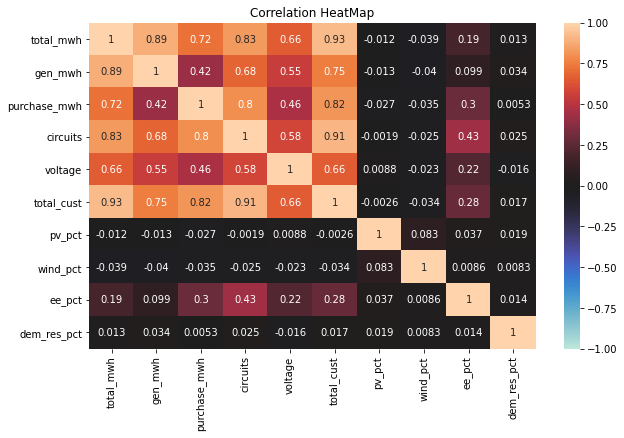

In [56]:
#creating pairwise correlation of columns using Pearson's R,
corr = train_X.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot=True, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

It looks like we have some amount of multicollinearity, specifically between **Circuits** and **total customers** and **voltage** and **total customers**. This makes sense because more customers require more distribution grid support. To solve this, we can probably get rid of total customers. **Net generation mwh** and **purchased mwh** are also highly correlated with **total customers**, but I may not include those two variables anyway because I will probably just use **total mwh sold** which should account for the predictive ability of all those variables.

In [57]:
# standard deviation of training outcome variable
train_y.describe()[2]

201.19478494086565

In [58]:
# take a look at how skewed each variable is
df.skew().sort_values(ascending = False)

dem_res_mwh          35.504972
wind_mwh             29.410157
saidi_nomed          16.552072
pv_mwh               15.312053
nm_mwh               15.084027
dem_res_pct          13.645533
dem_res_customers    10.823781
pv_pct               10.198893
wind_pct             10.126678
ee_mwh                9.680367
nm_pct                9.648539
voltage               8.170387
purchase_mwh          7.464751
total_cust            6.780508
ee_pct                6.433090
total_mwh             6.383701
circuits              5.753934
gen_mwh               5.429373
dem_res_cust_pct      4.523447
no                    1.410810
year                 -0.129646
dtype: float64

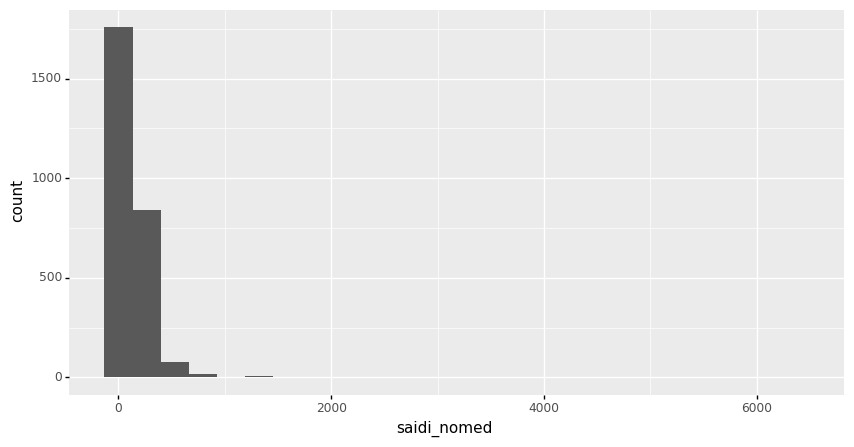

<ggplot: (8790593063949)>

In [59]:
# look at distribution of outcome
(
    ggplot(df,aes(x="saidi_nomed")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

# Explore Training Data

In [60]:
df

,year,name,state,total_mwh,total_cust,no,type,saidi_nomed,saifi_nomed,caidi_nomed,...,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,pv_pct,wind_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
0,2019.0,Adams Electric Coop,IL,176102.0,8931.0,97.0,Cooperative,169.740,1.29,131.5814,...,0.000,0.0,4402.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,49.288993
1,2019.0,Adams-Columbia Electric Coop,WI,515186.0,37607.0,108.0,Cooperative,139.900,0.95,147.26316,...,728.010,0.0,4781.0,13647.36,0.136994,0.004316,0.141310,0.000000,2.649016,12.713059
2,2019.0,Agralite Electric Coop,MN,238558.0,5251.0,155.0,Cooperative,128.759,1.181,109.0254,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2019.0,Aiken Electric Coop Inc,SC,938436.0,48059.0,162.0,Cooperative,97.720,.,.,...,354.456,3.0,0.0,0.00,0.037771,0.000000,0.037771,0.000320,0.000000,0.000000
4,2019.0,Alaska Electric Light&Power Co,AK,337796.0,17280.0,213.0,Investor Owned,79.000,2.08,37.980769,...,0.000,0.0,2386.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,13.807870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,2015.0,Southwest Iowa Rural Elec Coop,IA,98071.0,5909.0,49986.0,Cooperative,66.364,0.863,76.899189,...,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2695,2015.0,Entergy Gulf States - LA LLC,LA,16316827.0,298980.0,55936.0,Investor Owned,148.800,1.276,116.61442,...,0.000,9221.0,0.0,0.00,0.000000,0.000000,0.000000,0.056512,0.000000,0.000000
2696,2015.0,Entergy Texas Inc.,TX,17748084.0,432372.0,55937.0,Investor Owned,204.800,1.692,121.04019,...,2.509,39698.0,8.0,40.00,0.000014,0.000000,0.000014,0.223675,0.000225,0.001850
2697,2015.0,Black Hills/Colorado Elec.Util,CO,1918199.0,94835.0,56146.0,Investor Owned,81.834,1.257,65.102625,...,0.000,24140.0,0.0,0.00,0.000000,0.000000,0.000000,1.258472,0.000000,0.000000


## Continuous Variables

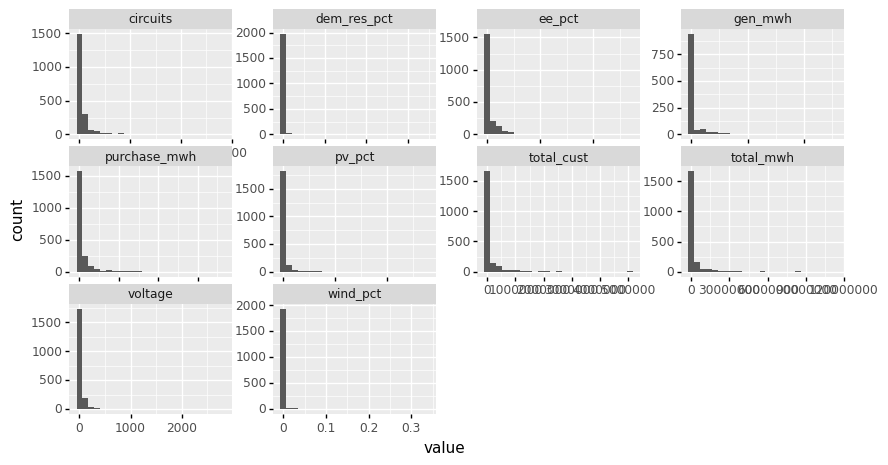

<ggplot: (8790593060809)>

In [61]:
# Plot the continuous variables 
df_num = train_X.select_dtypes(include="number").melt()

(
    ggplot(df_num,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

## Categorical Variables

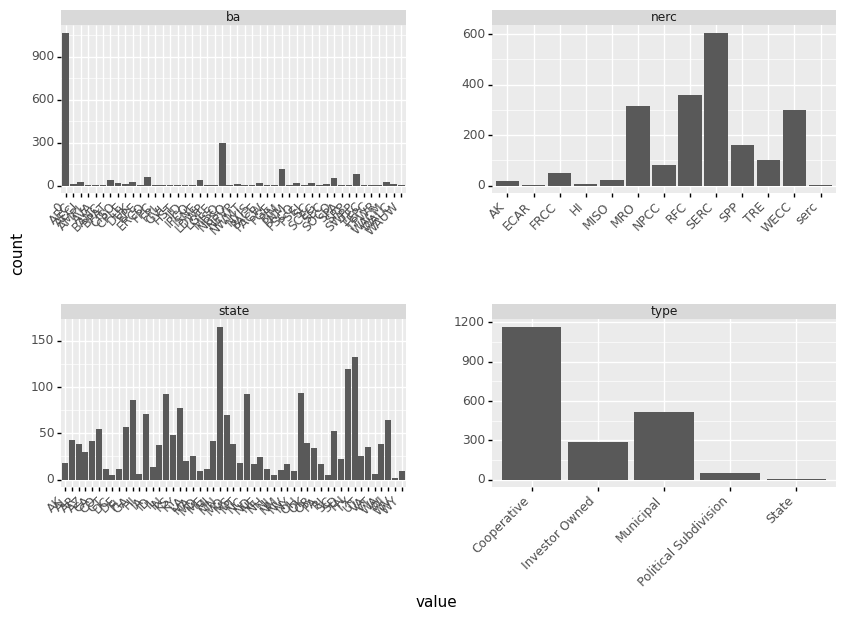

<ggplot: (8790592796253)>

In [62]:
# plot distributions of categorical variables
df_cat = train_X.select_dtypes(include="category").melt()

(
    ggplot(df_cat,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,6),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

### Let's dummify NERC regions, state, and utility type

In [65]:
nerc_dummies = pd.get_dummies(df.nerc)
nerc_dummies

,AK,ECAR,FRCC,HI,MISO,MRO,NPCC,RFC,SERC,SPP,TRE,WECC,serc
0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
# we'll use AK as our reference category
nerc_dummies = nerc_dummies.drop(['AK'],axis=1)

In [67]:
df = pd.concat([df.drop(['nerc'],axis=1),nerc_dummies],axis=1)

In [68]:
type_dummies = pd.get_dummies(df.type)

In [69]:
# we'll use State as our reference category
type_dummies = type_dummies.drop(['State'],axis=1)
type_dummies.head()

,Cooperative,Investor Owned,Municipal,Political Subdivision
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0


In [70]:
df = pd.concat([df.drop(['type'],axis=1),type_dummies],axis=1)

In [71]:
state_dummies = pd.get_dummies(df.state)

In [72]:
# we'll use AK as our reference category
state_dummies = state_dummies.drop(['AK'],axis=1)
state_dummies.head()

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
df = pd.concat([df.drop(['state'],axis=1),state_dummies],axis=1)

### Check dummifed categorical variables (continuous now)

In [97]:
y = df['saidi_nomed']
X = df.drop(columns=['no','name','total_cust','ba','year',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])

In [98]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

## Run Median Method

In [81]:
# all columns before the dummies
train_X.iloc[:,1:9].columns

Index(['total_mwh', 'circuits', 'voltage', 'pv_pct', 'wind_pct', 'ee_pct',
       'dem_res_pct', 'dem_res_cust_pct'],
      dtype='object')

In [85]:
# Version 2 use the medians and log total_mwh and circuits because that works
df_med = df.copy() 

# total_mwh and circuits logged
df_med['total_mwh'] = np.log(df['total_mwh'])
df_med['circuits'] = np.log(df['circuits'])

# voltage pct
median_voltage_pct = df.loc[df_med['voltage'] > 0,'voltage'].median()
df_med['voltage'] =  np.where(df_med['voltage']==0,0,np.where(df_med['voltage'] <= median_voltage_pct,1,2))

# pv pct
median_pv_pct = df.loc[df_med['pv_pct'] > 0,'pv_pct'].median()
df_med['pv_pct'] =  np.where(df_med['pv_pct']==0,0,np.where(df_med['pv_pct'] <= median_pv_pct,1,2))

# wind pct
median_wind_pct = df_med.loc[df_med['wind_pct'] > 0,'wind_pct'].median()
df_med['wind_pct'] =  np.where(df_med['wind_pct']==0,0,np.where(df_med['wind_pct'] <= median_wind_pct,1,2))

# energy efficiency pct
median_ee_pct = df_med.loc[df_med['ee_pct'] > 0,'ee_pct'].median()
df_med['ee_pct'] =  np.where(df_med['ee_pct']==0,0,np.where(df_med['ee_pct'] <= median_ee_pct,1,2))

# demand response pct
median_dr_pct = df_med.loc[df_med['dem_res_pct'] > 0,'dem_res_pct'].median()
df_med['dem_res_pct'] =  np.where(df_med['dem_res_pct']==0,0,np.where(df_med['dem_res_pct'] <= median_dr_pct,1,2))

# demand response customer pct
median_drc_pct = df_med.loc[df_med['dem_res_cust_pct'] > 0,'dem_res_cust_pct'].median()
df_med['dem_res_cust_pct'] =  np.where(df_med['dem_res_cust_pct']==0,0,np.where(df_med['dem_res_cust_pct'] <= median_drc_pct,1,2))

In [99]:
y = df_med['saidi_nomed']
X = df_med.drop(columns=['no','name','total_cust','ba', 'year',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])
train_X_med, test_X_med, train_y_med, test_y_med = train_test_split(X,y,test_size=.25,random_state=1997)

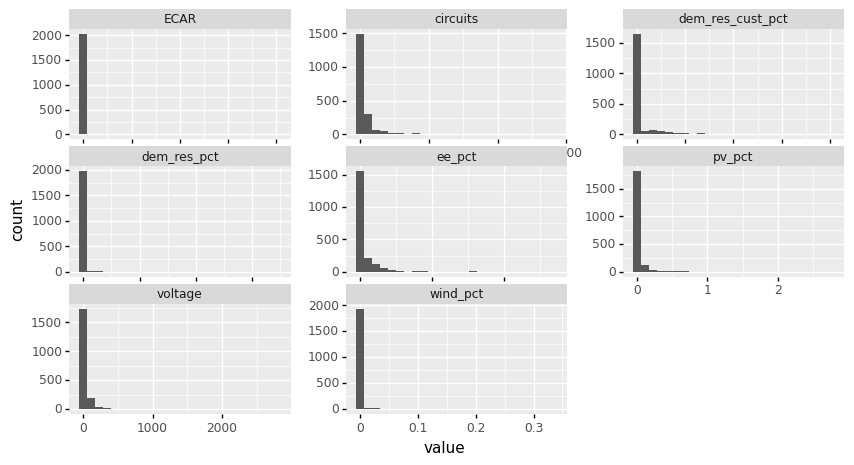

<ggplot: (8790591409701)>

In [100]:
d = train_X.iloc[:,1:9]

(
    ggplot(d.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

## Try them one by one

In [114]:
# EVERYTHING must hold constant other than the algorithm because we're looking for the best algorithm 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111) # make sure splits are same with random state

In [115]:
type(fold_generator)

sklearn.model_selection._split.KFold

In [116]:
# just MSE but negative, used by sklearn
use_metrics = ["neg_mean_squared_error"] 

In [117]:
lm_scores = cross_validate(LM(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [118]:
mod = LM()

In [120]:
mod.fit(train_X_med, train_y_med)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [121]:
knn_scores = cross_validate(KNN(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [122]:
dt_scores = cross_validate(DTree(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [123]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [124]:
# takes longer, because 1000 models 
rf_scores = cross_validate(RF(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [125]:
# Collect all the metrics we care about as a dictionary 
# name them by which method we used
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,1.188094e+04
1,lm,2.401518e+24
2,lm,2.906278e+04
3,lm,1.025469e+05
4,lm,1.517612e+04
5,knn,1.063411e+04
6,knn,2.396739e+04
7,knn,1.784989e+04
8,knn,1.064814e+05
9,knn,1.762981e+04


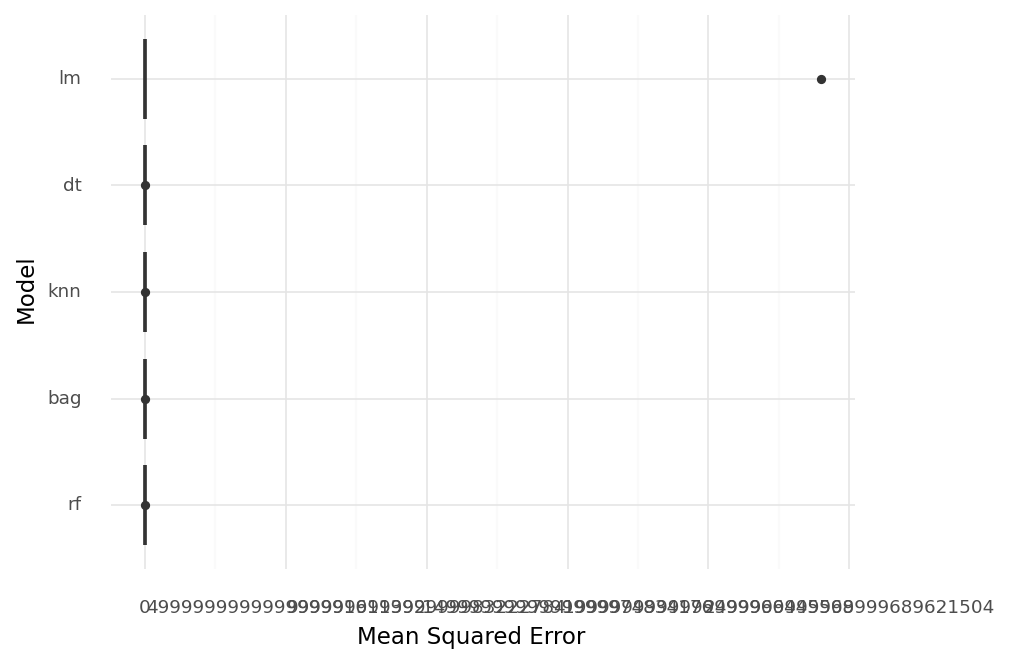

<ggplot: (8790591724329)>

In [126]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

## Tune RF

In [128]:
rf_params = {'n_estimators':[1225,1250,1275]} 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4,
                        verbose=10)

In [129]:
tune_rf.fit(train_X_med,train_y_med)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [130]:
tune_rf.best_params_

{'n_estimators': 1250}

In [131]:
tune_rf.best_score_

-31132.096258628917

# Build ML Pipeline

In [89]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

In [90]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(),  make_column_selector(dtype_exclude=None))])

In [91]:
# initialize our pipeline 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [92]:
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param, use double underscore to separate model from its parameter__
    {'model' : [KNN()],
     'model__n_neighbors':[15,20,23,25]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[1225,1250,1275]},
]

In [93]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4,
                      verbose = 10)

In [101]:
search.fit(train_X_med,train_y_med)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1873s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Batch computation too slow (4.5831s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done 117 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 14

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_trans

In [102]:
search.best_score_ # Mean out-of-sample (CV) error

-33973.802626198274

In [103]:
search.best_params_

{'model': BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)}

In [104]:
pred_y_med = search.predict(test_X_med)

In [105]:
m.mean_squared_error(test_y_med,pred_y_med)


27767.638771014743

In [106]:
m.r2_score(test_y_med,pred_y_med)


-0.6851400295882581

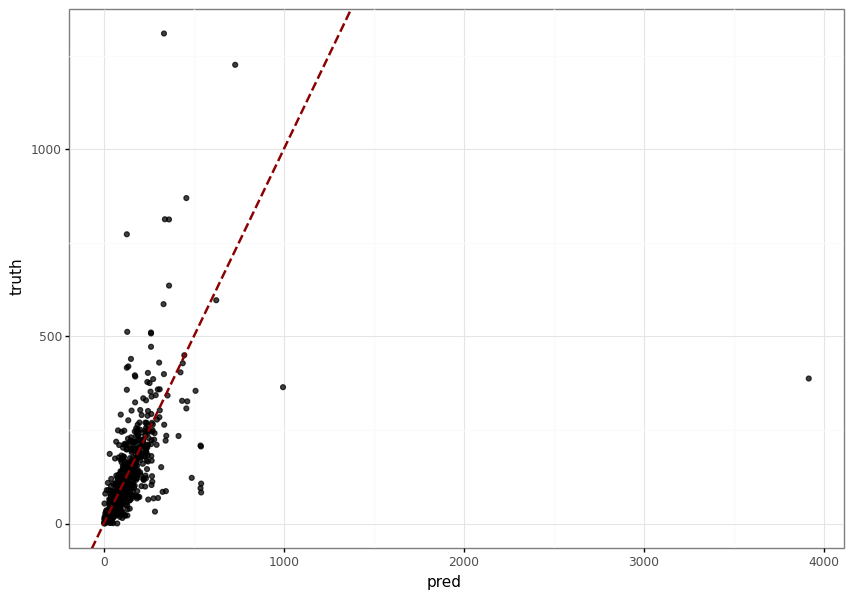

<ggplot: (8790594846373)>

In [107]:
# see how in the pipeline we preprocessed X so it is fixed beforehand and we can make sense of the predictions 
(
    ggplot(pd.DataFrame(dict(pred=pred_y_med,truth=test_y_med)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)